<a href="https://colab.research.google.com/github/Y07-assine/Machine-Deep-learning-for-Spam-classification/blob/main/SPAM_classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##SPAM classification task

In this lab, we'll build a Machine & Deep Learning models at the interface of NLP and Network Security areas through the use of SMS Spam Collection dataset with helping frameworks & libraries.

#Import required libraries and dataset

1. Download the dataset

In [1]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv

--2021-11-01 11:51:24--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   899KB/s    in 0.5s    

2021-11-01 11:51:26 (899 KB/s) - ‘spam.csv’ saved [503663/503663]



2. Import the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk, re, collections, pickle, os # nltk - Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# %matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

import warnings
warnings.filterwarnings(action = "ignore")
warnings.simplefilter(action = 'ignore', category = Warning)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Reading the dataset

The files contain one message per line. Each line consists of two columns: v1 contains the label (*ham* or *spam*) and v2 contains the raw text.

In [3]:
df_spam = pd.read_csv('spam.csv', encoding = 'latin-1')

In [4]:
df_spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


##Dataset manipulations & simple EDA

In [5]:
df_spam = df_spam.filter(['v1', 'v2'], axis = 1)
df_spam.columns = ['feature', 'message']
df_spam.drop_duplicates(inplace = True, ignore_index = True)

In [6]:
df_spam.head()

,feature,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print('Number of null values:\n')
df_spam.isnull().sum()

Number of null values:



feature    0
message    0
dtype: int64

In [8]:
df_spam['feature'].value_counts()

ham     4516
spam     653
Name: feature, dtype: int64

Dataset size & feature names

In [9]:
df_spam.shape, df_spam.columns

((5169, 2), Index(['feature', 'message'], dtype='object'))

- Let's describe the data in transposed way

In [12]:
df_spam.describe().T

,count,unique,top,freq
feature,5169,2,ham,4516
message,5169,5169,Hi neva worry bout da truth coz the truth will...,1


##Dataset primary statistics

Let's plot the number of value of both spam and ham messages

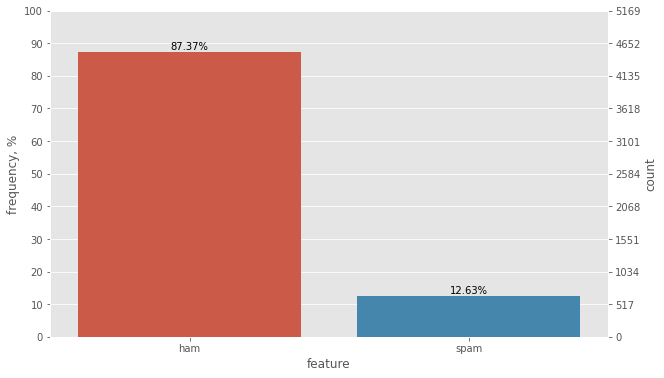

In [13]:
plt.figure(figsize = (10, 6))
counter = df_spam.shape[0]
ax1 = sns.countplot(df_spam['feature'])
ax2 = ax1.twinx()                      # Make double axis
ax2.yaxis.tick_left()                 # Switch so the counter's axis is on the right, frequency axis is on the left
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')  # Also switch the labels over
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('frequency, %')


for p in ax1.patches:
  x = p.get_bbox().get_points()[:, 0]
  y = p.get_bbox().get_points()[1, 1]
  ax1.annotate('{:.2f}%'.format(100. * y / counter),
              (x.mean(), y),
              ha = 'center',
              va = 'bottom')

# Use a LinearLocator to ensure the correct number of ticks
ax1.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0, 100)
ax1.set_ylim(0, counter)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

The number of ham messages is almost for times bigger than that of spam messages in the data.

Let’s plot the number of different most often used words present in our dataset.

In [14]:
def plot_words(set, number):
  words_counter = collections.Counter([word for sentence in set for word in sentence.split()]) # finding words along with count
  most_counted = words_counter.most_common(number)
  most_count = pd.DataFrame(most_counted, columns = ["Words", "Amount"]).sort_values(by = "Amount") # sorted data frame
  most_count.plot.barh(x = "Words", 
                       y = "Amount",
                       color = "blue",
                       figsize = (10, 15))
  for i, v in enumerate(most_count["Amount"]):
    plt.text(v, i,
             " " + str(v),
             color = 'black',
             va = 'center',
             fontweight = 'bold')

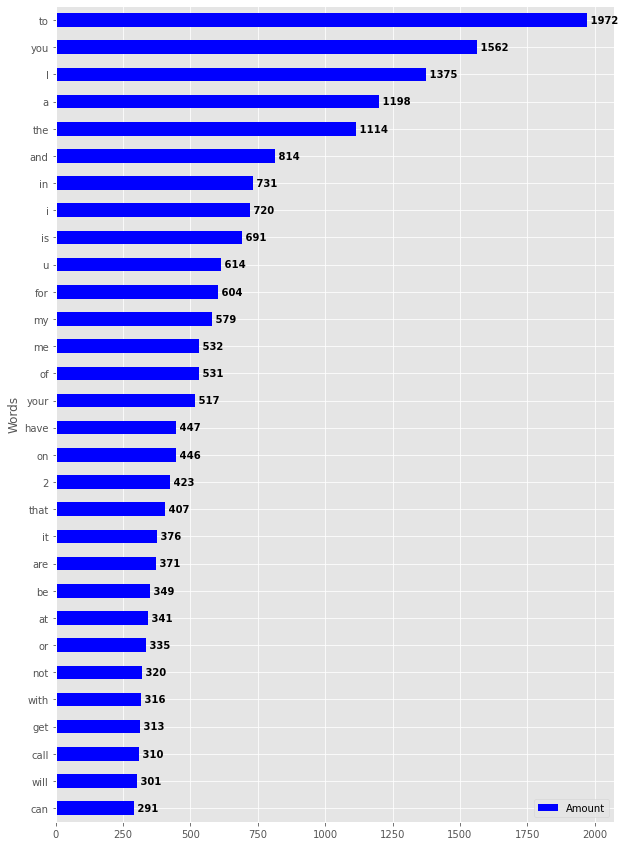

In [15]:
plot_words(df_spam['message'], number = 30)

- As you can see, the most often used words are *stopwords*. So we need to perform some preprocessing techniques on the dataset

Let's build the WordCloud image for the spam and the existed words (label ham) separately.

In [16]:
def word_cloud(tag):
  df_words_nl = ' '.join(list(df_spam[df_spam['feature'] == tag]['message']))
  df_wc_nl = WordCloud(width = 600, height = 512).generate(df_words_nl)
  plt.figure(figsize = (13, 9), facecolor = 'k')
  plt.imshow(df_wc_nl)
  plt.axis('off')
  plt.tight_layout(pad = 1)
  plt.show()

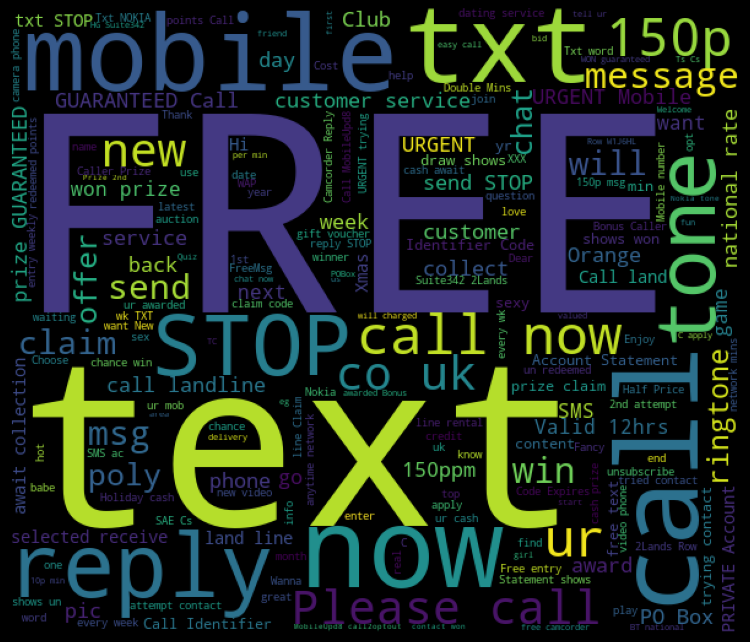

In [17]:
word_cloud('spam')

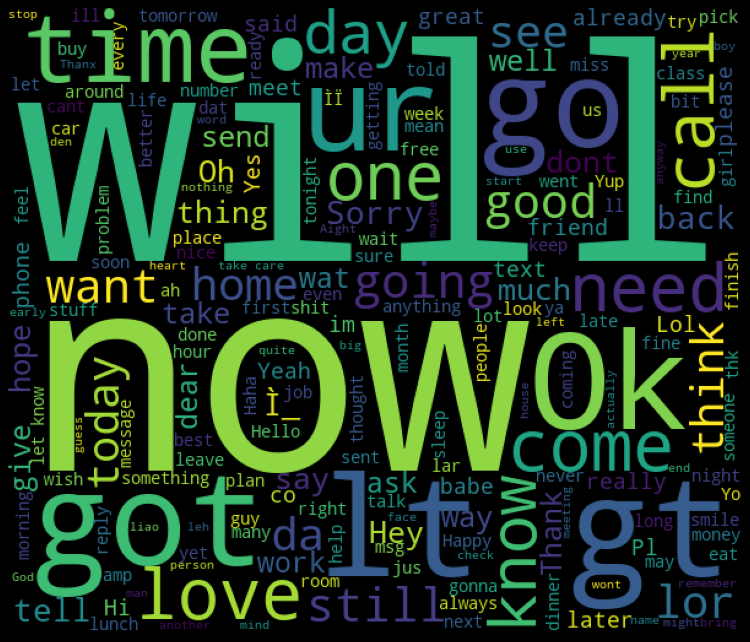

In [18]:
word_cloud('ham')

##Comparing different classification methods

1. Preparing of needed sets

We need to define some input parameters for our next research, such as the size of vocabulary, sizes of test & validation sets, dropping level, etc.

In [19]:
size_vocabulary = 1000  
embedding_dimension = 64 
trunc_type = 'post'
padding_type = 'post'
threshold = 0.5  
oov_token = "<OOV>"
test_size, valid_size = 0.05, 0.2
num_epochs = 20 
drop_level = 0.3 

- Data cleaning

Let's replace rules:

1.  email addresses with 'emailaddr';
2.  URLs with 'httpaddr';
3.  money symbols with 'moneysymb';
4.  phone numbers with 'phonenumbr';
5.  numbers with 'numbr';
6.  remove all punctuations;
7.  word to lower case.

We make a **lemmatization** which is a method of morphological analysis. It comes down to reducing a word form to its initial dictionary form (lemma). As a result of  word forms lemmatization, flexive endings are discarded and the main or dictionary form of the word is returned.

In [20]:
full_df_l = []
lemmatizer = WordNetLemmatizer()
for i in range(df_spam.shape[0]):
    mess_1 = df_spam.iloc[i, 1]
    mess_1 = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', mess_1)
    mess_1 = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', mess_1) 
    mess_1 = re.sub('£|\$', 'moneysymb', mess_1) 
    mess_1 = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', mess_1) 
    mess_1 = re.sub('\d+(\.\d+)?', 'numbr', mess_1) 
    mess_1 = re.sub('[^\w\d\s]', ' ', mess_1) 
    mess_1 = re.sub('[^A-Za-z]', ' ', mess_1).lower() 
    token_messages = word_tokenize(mess_1)
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')):
            mess.append(lemmatizer.lemmatize(word))
    txt_mess = " ".join(mess)
    full_df_l.append(txt_mess)

Now, let’s plot the count words once again to see the most frequent words (without any stopwords, thus after all cleaning stages).


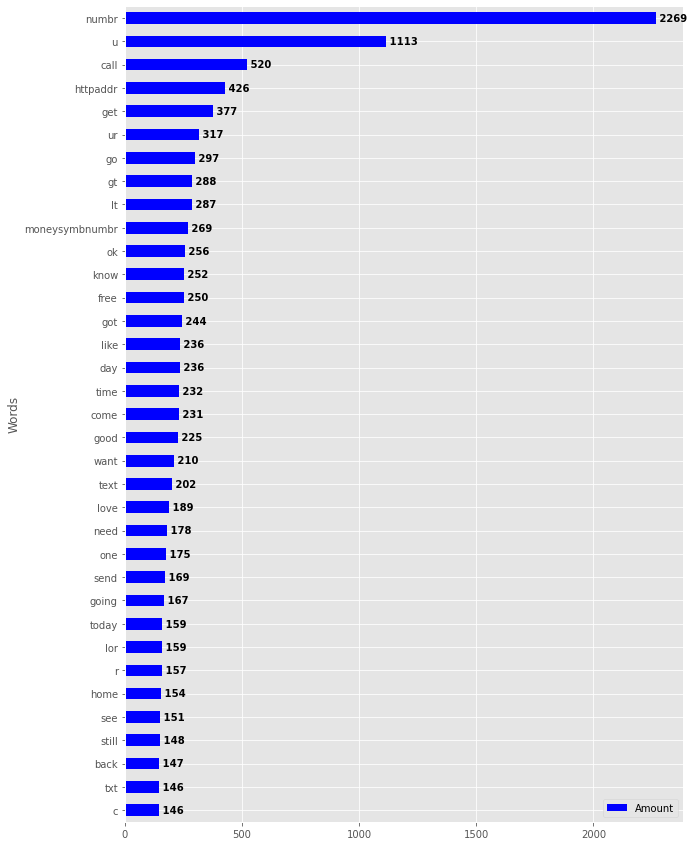

In [23]:
plot_words(full_df_l, number = 35)

We can see that most common words are different from the stopwords.

We will split the primary *df_spam* set into sentences (messages) and labels separately. Then we will split the full primary *df_spam* set with the following proportions: a training set (*75%*) and a test set (*25%*). Thus we will obtain 4 sets: two for sentences and two for labels with the same proportions.

Also, we will do the *vectorization* with the help of *CountVectorizer* method. This is an easy way to make a collection of text documents and create a dictionary of famous words. This method converts the input text to the matrix, the values of which are the numbers of this key entry (words) in the text

In [25]:
add_df = CountVectorizer(max_features = size_vocabulary) #size_vocabulary=1000
X = add_df.fit_transform(full_df_l).toarray()
y = df_spam.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (test_size + valid_size), random_state = seed)
print('Number of rows in test set: ' + str(X_test.shape))
print('Number of rows in training set: ' + str(X_train.shape))

Number of rows in test set: (1293, 1000)
Number of rows in training set: (3876, 1000)


2. Naive Bayes classifier

Let's find a set of predictions based on our models: *Guassian Naive Bayes* and *Multinomial Naive Bayes*.

In [42]:
def plot_conf_matr(conf_matr, classes,
                          normalize = False,
                          title = 'Confusion matrix',cmap=plt.cm.Blues):
  """
  Citation
  ---------
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """  
  import itertools

  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (12, 8))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 45)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()

		Classifier: Guassian Naive Bayes

The first two predicted labels: spam ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.77      0.86      1107
        spam       0.40      0.94      0.56       186

    accuracy                           0.79      1293
   macro avg       0.69      0.85      0.71      1293
weighted avg       0.90      0.79      0.82      1293
 



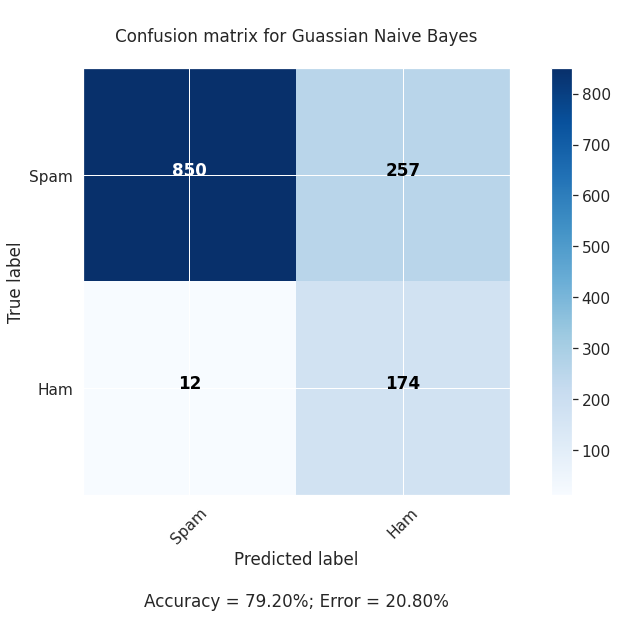

In [44]:
print("\t\tClassifier: Guassian Naive Bayes\n")
class_NBC = GaussianNB().fit(X_train, y_train) # Guassian Naive Bayes
y_pred_NBC = class_NBC.predict(X_test)
print('The first two predicted labels:', y_pred_NBC[0],y_pred_NBC[1], '\n')
conf_m_NBC = confusion_matrix(y_test, y_pred_NBC)
class_rep_NBC = classification_report(y_test, y_pred_NBC)
print('\t\t\tClassification report:\n\n', class_rep_NBC, '\n')
plot_conf_matr(conf_m_NBC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Guassian Naive Bayes')

		Classifier: Multinomial Naive Bayes

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1107
        spam       0.90      0.92      0.91       186

    accuracy                           0.97      1293
   macro avg       0.94      0.95      0.95      1293
weighted avg       0.97      0.97      0.97      1293
 



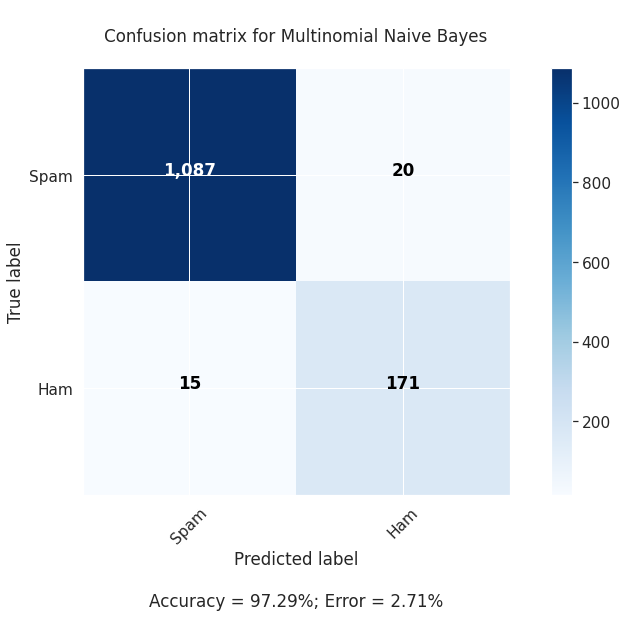

In [45]:
print("\t\tClassifier: Multinomial Naive Bayes\n")
class_MNB = MultinomialNB().fit(X_train, y_train) # Multinomial Naive Bayes
y_pred_MNB = class_MNB.predict(X_test)
print('The first two predicted labels:', y_pred_MNB[0],y_pred_MNB[1], '\n')
conf_m_MNB = confusion_matrix(y_test, y_pred_MNB)
class_rep_MNB = classification_report(y_test, y_pred_MNB)
print('\t\t\tClassification report:\n\n', class_rep_MNB, '\n')
plot_conf_matr(conf_m_MNB, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Multinomial Naive Bayes')

3. Decision tree classifier

		Classifier: Decision Tree Classifier

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1107
        spam       0.87      0.84      0.86       186

    accuracy                           0.96      1293
   macro avg       0.92      0.91      0.92      1293
weighted avg       0.96      0.96      0.96      1293
 



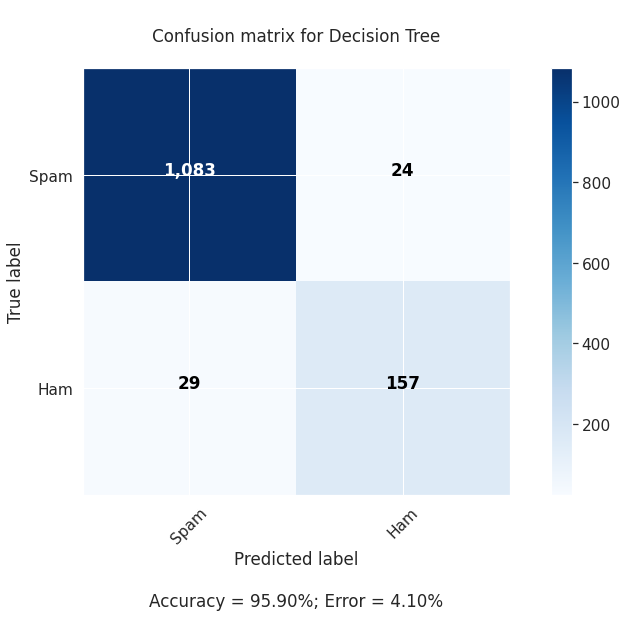

In [46]:
print("\t\tClassifier: Decision Tree Classifier\n")
class_DTC = DecisionTreeClassifier(random_state = seed).fit(X_train, y_train)
y_pred_DTC = class_DTC.predict(X_test)
print('The first two predicted labels:', y_pred_DTC[0], y_pred_DTC[1], '\n')
conf_m_DTC = confusion_matrix(y_test, y_pred_DTC)
class_rep_DTC = classification_report(y_test, y_pred_DTC)
print('\t\t\tClassification report:\n\n', class_rep_DTC, '\n')
plot_conf_matr(conf_m_DTC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Decision Tree')

4. Logistic regression

		Stage IV. Logistic Regression

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.97      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



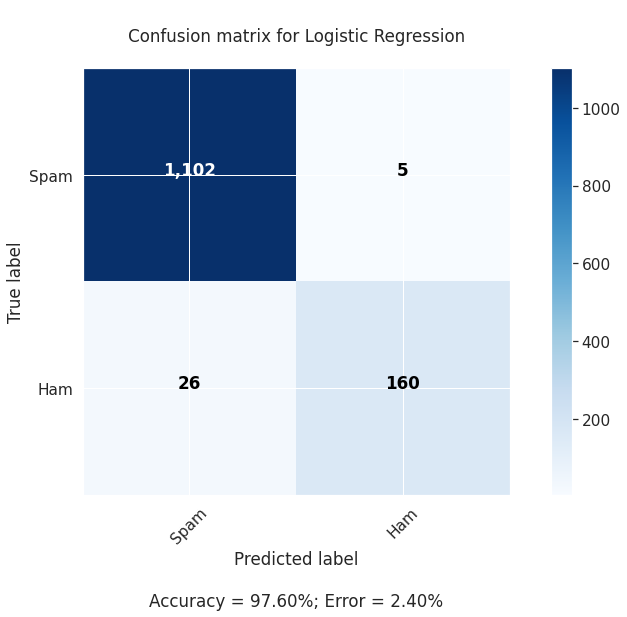

In [47]:
print("\t\tStage IV. Logistic Regression\n")
class_LR = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = class_LR.predict(X_test)
print('The first two predicted labels:', y_pred_LR[0], y_pred_LR[1], '\n')
conf_m_LR = confusion_matrix(y_test, y_pred_LR)
class_rep_LR = classification_report(y_test, y_pred_LR)
print('\t\t\tClassification report:\n\n', class_rep_LR, '\n')
plot_conf_matr(conf_m_LR, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Logistic Regression')

5. KNeighbors Classifier

		Stage V. KNeighbors Classifier

The firs two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.95      0.99      0.97      1107
        spam       0.93      0.70      0.80       186

    accuracy                           0.95      1293
   macro avg       0.94      0.85      0.89      1293
weighted avg       0.95      0.95      0.95      1293
 



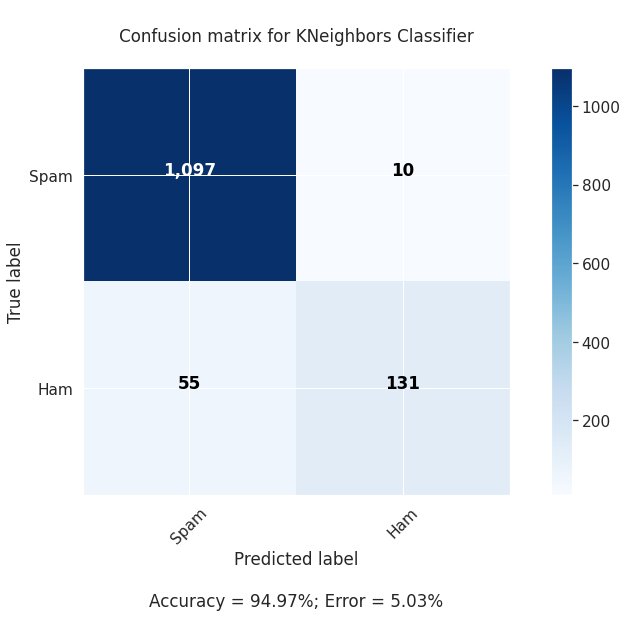

In [48]:
print("\t\tStage V. KNeighbors Classifier\n")
class_KNC = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
y_pred_KNC = class_KNC.predict(X_test)
print('The firs two predicted labels:', y_pred_KNC[0], y_pred_KNC[1], '\n')
conf_m_KNC = confusion_matrix(y_test, y_pred_KNC)
class_rep_KNC = classification_report(y_test, y_pred_KNC)
print('\t\t\tClassification report:\n\n', class_rep_KNC, '\n')
plot_conf_matr(conf_m_KNC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for KNeighbors Classifier')

6. Support Vector Classification

		Stage VI. Support Vector Classification

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.98      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



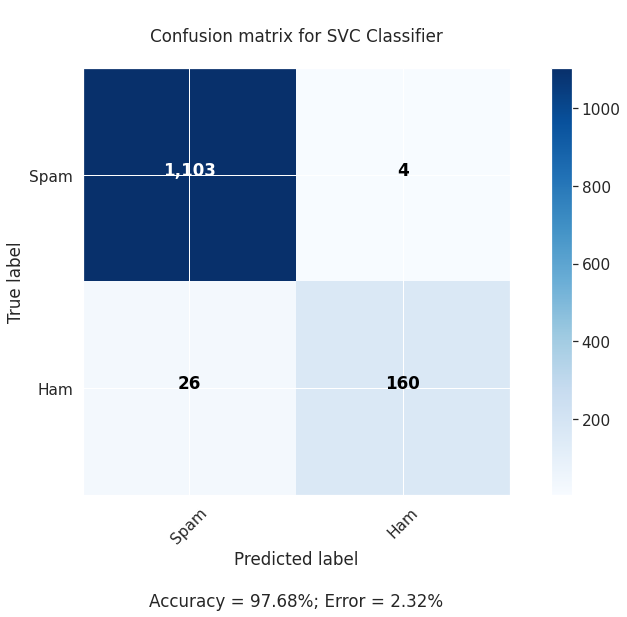

In [49]:
print("\t\tStage VI. Support Vector Classification\n")
class_SVC = SVC(probability = True, random_state = seed).fit(X_train, y_train)
y_pred_SVC = class_SVC.predict(X_test)
print('The first two predicted labels:', y_pred_SVC[0], y_pred_SVC[1], '\n')
conf_m_SVC = confusion_matrix(y_test, y_pred_SVC)
class_rep_SVC = classification_report(y_test, y_pred_SVC)
print('\t\t\tClassification report:\n\n', class_rep_SVC, '\n')
plot_conf_matr(conf_m_SVC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for SVC Classifier')

- We can see that Logistic regression and SVC gives the better results

###Deep Learning for SPAM classification 

1. Preparing of needed sets

the primary *df_spam* set will split into sentences (messages) and labels separately. Then we will split the full primary *df_spam* set with the following proportions: a training set (*75%*), a validation set (*20%*) and a test set (*5%*). Thus we will obtain 6 sets: three for sentences and three for labels with the same proportions.


In [50]:
sentences_new_set = []
labels_new_set = []
for i in range(0, df_spam.shape[0], 1):
    sentences_new_set.append(df_spam['message'][i])
    labels_new_set.append(df_spam['feature'][i])

In [52]:
train_size = int(df_spam.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df_spam.shape[0] * (1 - valid_size))

train_sentences = sentences_new_set[0 : train_size]
valid_sentences = sentences_new_set[train_size : valid_bound]
test_sentences = sentences_new_set[valid_bound : ]

train_labels_str = labels_new_set[0 : train_size]
valid_labels_str = labels_new_set[train_size : valid_bound]
test_labels_str = labels_new_set[valid_bound : ]

2. Labels transformations

 we will replace all the labels (ham and spam) to the appropriate values *1* and *0*, and transform them to Numpy arrays.

In [68]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = le.fit_transform(train_labels_str)
valid_labels = le.fit_transform(valid_labels_str)
test_labels = le.fit_transform(test_labels_str)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

3. Tokenization

*Tokenization* is a process of splitting up a large body of text into smaller lines or words. It helps in interpreting the meaning of the text by analyzing the sequence of the words. We converted our output feature into a numerical form, then, what about the input feature based on *size_vocabulary*.

First, let’s tokenize our data and convert it into a numerical sequence using Keras Tokenizer. We can also find the index number word_index of the corresponding words.
 We will need a really big word index to handle sentences that are not in the training set. This can be handled using the Out Of Vocabulary <OOV> token variable oov_token.

In [70]:
tokenizer = Tokenizer(num_words = size_vocabulary, #=1000
                      oov_token = oov_token,
                      lower = False)

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [72]:
print(word_index)

{'<OOV>': 1, 'to': 2, 'you': 3, 'I': 4, 'a': 5, 'the': 6, 'and': 7, 'i': 8, 'in': 9, 'is': 10, 'u': 11, 'me': 12, 'for': 13, 'my': 14, 'of': 15, 'it': 16, 'your': 17, 'have': 18, 'on': 19, 'that': 20, '2': 21, 'are': 22, 'now': 23, 'at': 24, 'not': 25, 'be': 26, 'or': 27, 'call': 28, 'U': 29, 'get': 30, 'with': 31, 'will': 32, 'lt': 33, 'gt': 34, 'can': 35, 'so': 36, 'but': 37, 'up': 38, "I'm": 39, 'You': 40, '4': 41, 'out': 42, 'ur': 43, 'do': 44, 'from': 45, 'know': 46, 'just': 47, 'go': 48, 'like': 49, 'when': 50, 'we': 51, 'this': 52, 'all': 53, 'if': 54, 'am': 55, 'come': 56, 'got': 57, 'time': 58, 'then': 59, 'No': 60, 'there': 61, 'was': 62, 'day': 63, 'only': 64, 'want': 65, 'going': 66, 'lor': 67, 'by': 68, 'home': 69, 'love': 70, 'good': 71, 'what': 72, 'one': 73, 'no': 74, 'ok': 75, 'Call': 76, 'about': 77, 'send': 78, 'as': 79, 'need': 80, 'How': 81, 'still': 82, 'text': 83, 'how': 84, 'he': 85, 'back': 86, 'n': 87, 'Ok': 88, 'But': 89, 'our': 90, 'its': 91, 'Ì': 92, 'here'

all the sequences are of different lengths which are not compatible for the model to train. So we should make all the sentences length equal. For this, we are padding the sequences with padding_type.

In [73]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
size_voc = len(word_index) + 1
max_len = max([len(i) for i in train_sequences])

train_set = pad_sequences(train_sequences,
                                padding = padding_type,
                                maxlen = max_len,
                                truncating = trunc_type) 

valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_set = pad_sequences(valid_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_set = pad_sequences(test_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

4. Model building

- The first layer of the model is *Embedding* layer, which can be used to create *dense* encoding of words based on an input *size_voc* of defined vocabulary (in our case it's the index number *word_index* of the corresponding words *+ 1*). Typically sparse and dense word encodings denote coding efficiency.
- Using `bidirectional LSTM` will run your input in two ways: one from the past to the future and one from the future to the past (in a back way). This distinguishes this approach from `unidirectional LSTM` which works in the opposite direction, so you save information from the future. Thus, by using the two hidden states together, you can save information from both the past and the future at any time.
- `Dropout` is used in neural networks to solve the problem of overfitting. Networks for training are obtained by dropping out neurons with probability `p`, so the probability that a neuron will remain in the network is `1 - p`.
- `Dense` layer is an ordinary tightly bonded layer of a neural network where each neuron is connected to all inputs.



In [74]:
model = Sequential([
    Embedding(size_voc, embedding_dimension, input_length = max_len),
    Bidirectional(LSTM(100)),
    Dropout(drop_level),
    Dense(20, activation = 'relu'),
    Dropout(drop_level),
    Dense(1, activation = 'sigmoid')
])

5. Model compiling & fitting

Let's set some hyperparameters & other variables values, such as batch size, number of epochs for training, types of optimizer & loss function.

In [75]:
optim = Adam(learning_rate = 0.0001)

model.compile(loss = 'binary_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 64)           606080    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                4020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 742,121
Trainable params: 742,121
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(train_set, 
                    train_labels,
                    epochs = num_epochs, 
                    validation_data = (valid_set, valid_labels),
                    workers = os.cpu_count(),
                    use_multiprocessing = True,
                    verbose = 1)

Epoch 1/20
122/122 [==============================] - 37s 275ms/step - loss: 0.4966 - accuracy: 0.8620 - val_loss: 0.3233 - val_accuracy: 0.8803
Epoch 2/20
122/122 [==============================] - 33s 270ms/step - loss: 0.2838 - accuracy: 0.8695 - val_loss: 0.2493 - val_accuracy: 0.8803
Epoch 3/20
122/122 [==============================] - 33s 271ms/step - loss: 0.2112 - accuracy: 0.9211 - val_loss: 0.2006 - val_accuracy: 0.9228
Epoch 4/20
122/122 [==============================] - 33s 269ms/step - loss: 0.1606 - accuracy: 0.9569 - val_loss: 0.1705 - val_accuracy: 0.9421
Epoch 5/20
122/122 [==============================] - 33s 269ms/step - loss: 0.1243 - accuracy: 0.9641 - val_loss: 0.1674 - val_accuracy: 0.9459
Epoch 6/20
122/122 [==============================] - 33s 268ms/step - loss: 0.0982 - accuracy: 0.9747 - val_loss: 0.0988 - val_accuracy: 0.9730
Epoch 7/20
122/122 [==============================] - 33s 269ms/step - loss: 0.0777 - accuracy: 0.9807 - val_loss: 0.0786 - val_ac

6. Results visualisation 

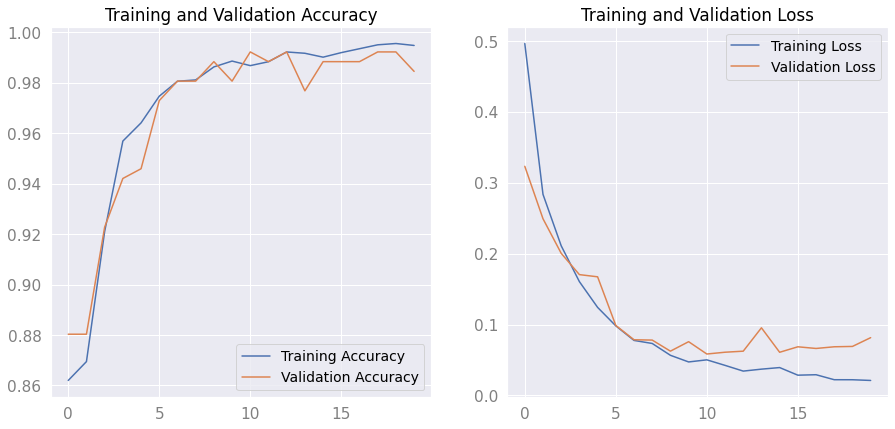

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

let's estimate your pre-built model on the test set which this model hasn't seen in any case.


In [85]:
model_score = model.evaluate(test_set, test_labels, batch_size = embedding_dimension, verbose = 1)
print(f"Test accuracy: {model_score[1] * 100:0.2f}% \t\t Test error: {model_score[0]:0.4f}")

17/17 [==============================] - 2s 97ms/step - loss: 0.0699 - accuracy: 0.9845
Test accuracy: 98.45% 		 Test error: 0.0699


7. Model saving

In [87]:

pickle.dump(tokenizer, open("spam_model" + ".pkl", "wb"))
filepath = 'spam_model.h5'
tf.keras.models.save_model(model, filepath, include_optimizer = True, save_format = 'h5', overwrite = True)
print("Size of the saved model :", os.stat(filepath).st_size, "bytes")

Size of the saved model : 8964368 bytes


			Classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       917
           1       0.96      0.90      0.93       117

    accuracy                           0.98      1034
   macro avg       0.98      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034
 



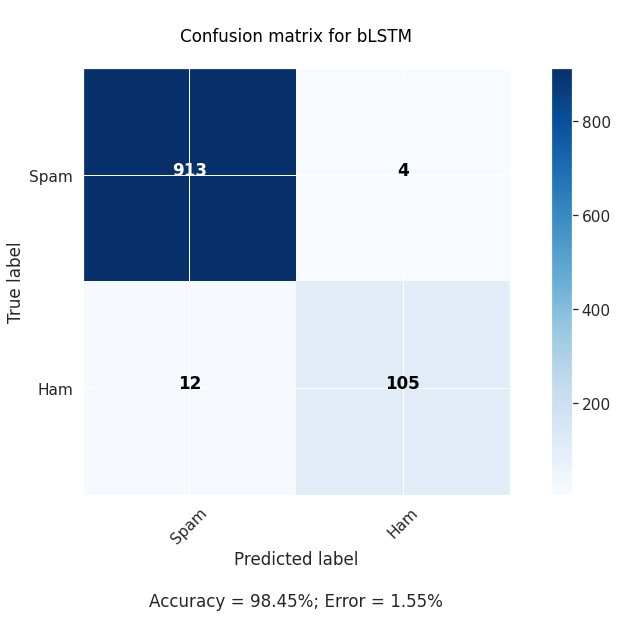

In [94]:
y_pred_bLSTM = model.predict(test_set)

y_prediction = [0] * y_pred_bLSTM.shape[0]
for ind, item in enumerate(y_pred_bLSTM):
    if item > threshold:
        y_prediction[ind] = 1
    else:
        y_prediction[ind] = 0

conf_m_bLSTM = confusion_matrix(test_labels, y_prediction)
class_rep_bLSTM = classification_report(test_labels, y_prediction)
print('\t\t\tClassification report:\n\n', class_rep_bLSTM, '\n')
plot_conf_matr(conf_m_bLSTM, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for bLSTM')

Let's check our trained model on the real messages which you can create yourself.

In [96]:
message_example = ["Hi, don't forget our to send the final result tonight"] 

message_example_tp = pad_sequences(tokenizer.texts_to_sequences(message_example),
                                   maxlen = max_len,
                                   padding = padding_type,
                                   truncating = trunc_type)

pred = float(model.predict(message_example_tp))
if (pred > threshold):
    print ("This message is a spam message")
else:
    print("This message is a real text")

This message is a real text
